In [1]:
library(data.table) 
library(lmtest)
library(stargazer)

set.seed(1)

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Please cite as: 

 Hlavac, Marek (2015). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2. http://CRAN.R-project.org/package=stargazer 



# Simple Linear Algebra Underlying the Models

Let's think a little bit about what is going on in those models, and what they're telling us. 

1. The values of the regression coefficient are identical. This underlies an important point: *when we talk about robust standard errors, we are correcting our estimates of uncertainty, not the actual point estimate*. Consider the plot above, what is the best fitting line to this plot? Does the heteroskedasticity change what is the best fitting plot? **No**! We can see this on technical grounds, because the OLS solution that is being fit simply solves for $$\hat{\beta} = (X'X)^{-1}X'Y.$$ If you want to put this into a notional system that is based on covariance, you can: $(X'X)^{-1}$ is basically like: $\frac{1}{Cov(X,X)} = \frac{1}{Var(X)}$ and $X'Y$ is basically like $Cov(X,Y)$. So, the linear algebra solution is just the statement $$\frac{Cov(X,Y)}{Var(X)}.$$ With this, note that the heteroskedasticy in $Y$ does not affect the $Var(X)$ term. Neither does it affect the $Cov(X,Y)$ term, at least not with the data that we are using to estimate. The nature of heteroskedasticy is that there is increased variance in $Y$, and importantly, the presence of this unequal variance would change the correlation with $X$ (basically decreasing it as noise increases), *but* this isn't the case. Because we only "have" or observe the data that we "have" or observe! So, whether it is heteroskedastic or homoskedastic, the relationship that we estimate is based on what we see. 

To show this last point, consider this code: 


In [2]:
d <- data.table(
    'id' = 1:1000, 
    'x'  = runif(n = 1000, min = 0, max = 10)
    )

d[ , ':='(y1 = x + rnorm(n = .N, mean = 0, sd = 2), 
          y2 = x + rnorm(n = .N, mean = 0, sd = 10))]

*In this code block above, we're using the `functional assign` in data.table. This reads as*

> In the data table `d`, for all rows, assign: 
> - `y1` to be `x` plus random draws from a normal distribution with mean zero and sd of 2; and,
> - `y2` to be x plaus random draws from a normal distribution with mean zero and sd of 10. 

NULL

NULL

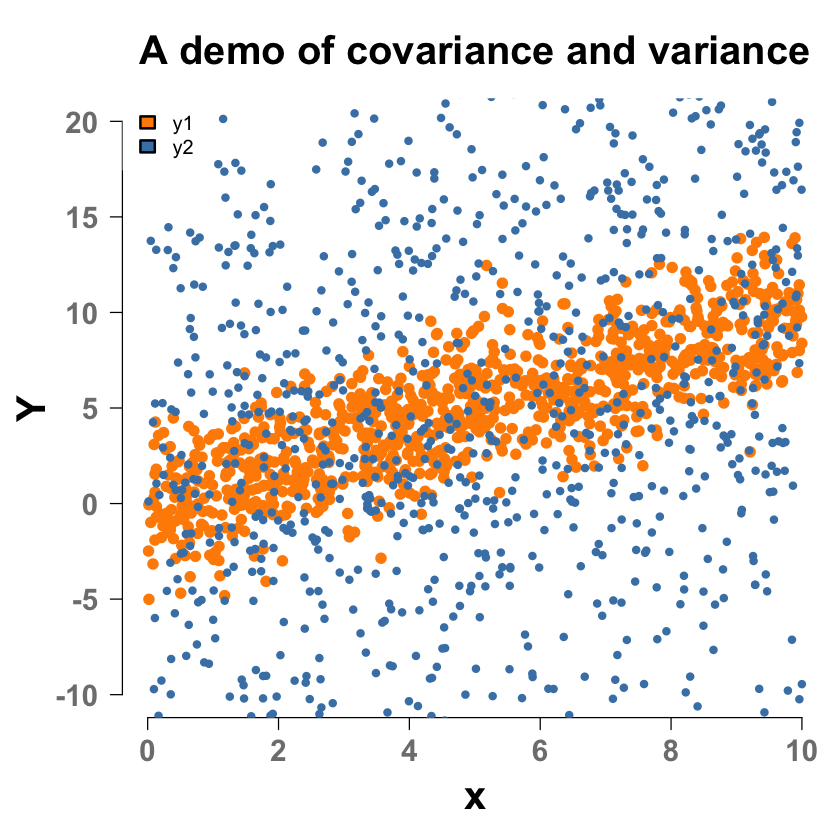

In [3]:
source("http://ischool.berkeley.edu/~d.alex.hughes/code/pubPlot.R")

d[ , plot(x, y1, 
          main = "A demo of covariance and variance", 
          pch = 19, col = "darkorange", 
          ylim = c(-10, 20), ylab = "Y")] 
d[ , points(x, y2, pch = 20, col = "steelblue")]
legend("topleft", fill = c("darkorange", "steelblue"),  bg = "white", 
       box.lwd = 0, legend = c("y1", "y2"), )


In this plot, the `x` points are drawn from the same location. And, there is a 1-1 relationship between `x` and `y1` and `y2`, though `y2` has some more variance. 

In [4]:
sprintf("The covariance between x and y1 is %.2f.", d[,cov(x,y1)])
sprintf("The covariance between x and y2 is %.2f.", d[,cov(x,y2)])

[1] "The covariance between x and y1 is 8.35."

[1] "The covariance between x and y2 is 8.46."

In [5]:
m1 <- d[ , lm(y1 ~ x)]
m2 <- d[ , lm(y2 ~ x)]

stargazer(m1, m2, type = 'text')


                                   Dependent variable:     
                               ----------------------------
                                     y1             y2     
                                     (1)           (2)     
-----------------------------------------------------------
x                                 1.004***       1.017***  
                                   (0.023)       (0.116)   
                                                           
Constant                           -0.070         -0.186   
                                   (0.131)       (0.667)   
                                                           
-----------------------------------------------------------
Observations                        1,000         1,000    
R2                                  0.663         0.072    
Adjusted R2                         0.662         0.071    
Residual Std. Error (df = 998)      2.068         10.541   
F Statistic (df = 1; 998)       1,959.4

2. The estimation of the standard error depends *in a real way* on an assumption made by the data scientist. Here, we show this. Recall that $$\hat{\beta} = (X'X)^{-1}X'Y.$$ Rather naturally, we can just then say that the $Var(\hat{\beta})$ is just the variance of that quantity. Or, $$Var(\hat{\beta}) = Var((X'X)^{-1}X'Y)$$. If the data that we have is the data that we have (e.g. we're not in the technical case of random regressors... don't worry about this deeply...) then we can use some pretty easy variance properties to manipulate this. 

Specifically, we know (can know (can demonstrate (can Google))), that $Var(aX)$, where $a$ is a constant is just $a^{2}Var(X)$. 

Then, we can apply this to our statement above that is the linear algebra solution for the best fitting relationship. In this case, since we have the data that we have, all of Xs are effectively constants, so we treatment them as such in the variance identity we just wrote down. Here though, because we're working within a linear algebra setup, we just need to represent this in the quadratic form which is $aa'$: 

\begin{align*}
Var\left[\hat{\beta}\right] & = Var\left[ (X'X)^{-1}X'Y\right] \\ 
  & = a Var\left[Y \right] a' \text{, where } a = (X'X)^{-1}X' \\ 
  & = (X'X)^{-1}X' Var\left[ Y \right] \left[(X'X)^{-1}X'\right]' \\ 
  & = (X'X)^{-1}X' Var\left[ Y \right] X(X'X)^{-1} \\ 
\end{align*}

At this point, if we could meet the standard assumptions of OLS, namely that there is constant (across $X$), uncorrelated variance, we could just replace $Var\left[ Y \right]$ with $\sigma^{2}I_{n}$, which just has $\sigma^{2}$ on the diagonal and 0s everywhere else. But this is just identical to some constant, perhaps called $\sigma^{2}_{y}$. (As an aside, since we do not *know* the variance of Y, but rather have to estimate, some places call $\sigma^{2}_{y}$ instead $s^{2}$ which they mean to be the unbiased, efficient estimator of the sample variance which is calculated as the sum of squared residuals of Y after fitting the regression). 

Soldiering on... 

\begin{align*}
  & = (X'X)^{-1}X' \sigma^{2}_{y}X(X'X)^{-1} \\  
  & = \sigma^{2}_{y} * (X'X)^{-1}X'X(X'X)^{-1} \\ 
  & = \sigma^{2}_{y} * I_{n} * (X'X)^{-1} \\ 
\end{align*}

Note, in the second to last line that $(X'X)^{-1}X'X$ is just the identity matrix of dimension $(n,n), which I just call $I_{n}$. 

In fact, the last line of this solution is the normal solution for the standard error of a regression coefficient. That is, the  it is the sum of the squared residuals, divided by the variance-covariance matrix of the X values. 

But, what happens if we *can't* make that jump? What if we can't call it something that is is the same on all the diagonals, and so just plunks out up front? This is really the case that we're talking about with the Heteroskedastic Consistent (often called Huber-White, White's, or just *robust* ) standard errors. 

In essence, if we cannot make this assumption, then we are left with this situation, where $\Sigma$ is a (n,n) matrix that potentially has different values in each of its diagonal entries (I will note that we still assume that the off-diagonal entries are zero). 

White's solution was just to estimate the value of $\Sigma$ using a consistent estimator, namely the sum of the squared residuals, or $\epsilon'\epsilon$, where the $\epsilon$ are just drawn from the regression residuals. Zing! This is feasible, and actually pretty easy to do! 

\begin{align*}
  & = (X'X)^{-1}X' \Sigma X(X'X)^{-1} \\ 
  & = (X'X)^{-1}X'\epsilon'\epsilon X(X'X)^{-1} \\
\end{align*} 

This is often times also called the *sandwitch* estimator, because the "meat" of the estimator, the calculation of the sum of squared residuals $\epsilon'\epsilon$, is surrounded by the "bread" that is the $(X'X)^{-1}X'$. Note that here $\epsilon$ is just the difference between the observed $Y$ and the $X\beta$ projection, and so, any calculation of the residuals must necessarily occur after estimation. 


# Estimating Those Models 

This little demo will show why getting the standard errors calculated correctly is important. We're going to use a few packages: 

- `sandwich` which provides robust standard error estimators 
- `lmtest` which provides a unifying framework to test coefficients 
- `stargazer` which provides some nice, pretty tables 

# Make function 
This isn't strictly necessary, but since we're going to be repeatedly creating robust standard error estimates, we might want to write a little function to do so. This function estimates the robust variance-covariance matrix, and then calculates the square root of the diagonal which is the standard error for each of the coefficients. 


In [6]:
r.se <- function(model, error.type) { 
  require(sandwich, quietly = TRUE) 
  vcov <- vcovHC(x = model, type = error.type)
  se <- sqrt(diag(vcov))
  return(se)
}

Create some data that has a particular, unique, and instructive shape. 

- In `y1` make a lot of dispersion in the values at the edges of the vector, but relatively little near the center of the vector. 
- In `y2` make relatively little dispersion of the values at the edges of the vector, but relatiely a lot near the center of the vector. 

In [7]:
d <- data.table('id' = 1:200)
d[ , ':='(y1 = rnorm(n = 200, mean = rep(1:25, 8), sd = rep(c(100:1, 1:100))),
          y2 = rnorm(n = 200, mean = rep(1:25, 8), sd = rep(c(1:100, 100:1))), 
          x  = sort(rnorm(.N)))]
d[1:4]

id,y1,y2,x
1,-179.54836,0.5946608,-2.885018
2,-65.12603,5.8813430,-2.777593
3,-43.38909,4.4548958,-2.691768
4,103.65946,3.1916109,-2.625883


Note, with the data that we've created here, the pattern than exists with the data in the `Y` dimension. We have quite precise statements about the location of the data when `X` is around zero, but we have both much less data when X is relatively far away from zero, and we have relatively greater dispersion when we are at those locations. 

A concrete example of data that might look like this is data where X is IQ, and Y is time spent gardening. People with normal IQs, the IQs that are the most frequent in the daily world, spend a consistent time gardening: they water their tomatoes before work each day, and that is all. In contrast, people at the high ends of the IQ distribution (you all) have highly variable time spent gardening. Some of you are working 80 hours per week, and also taking MIDS and raising a family. People in this situation are not likely spending much time watering the plants; others of you are only taking MIDS, and so when you're frustrated with a problem set, you take a break and water the plants. 


NULL

NULL

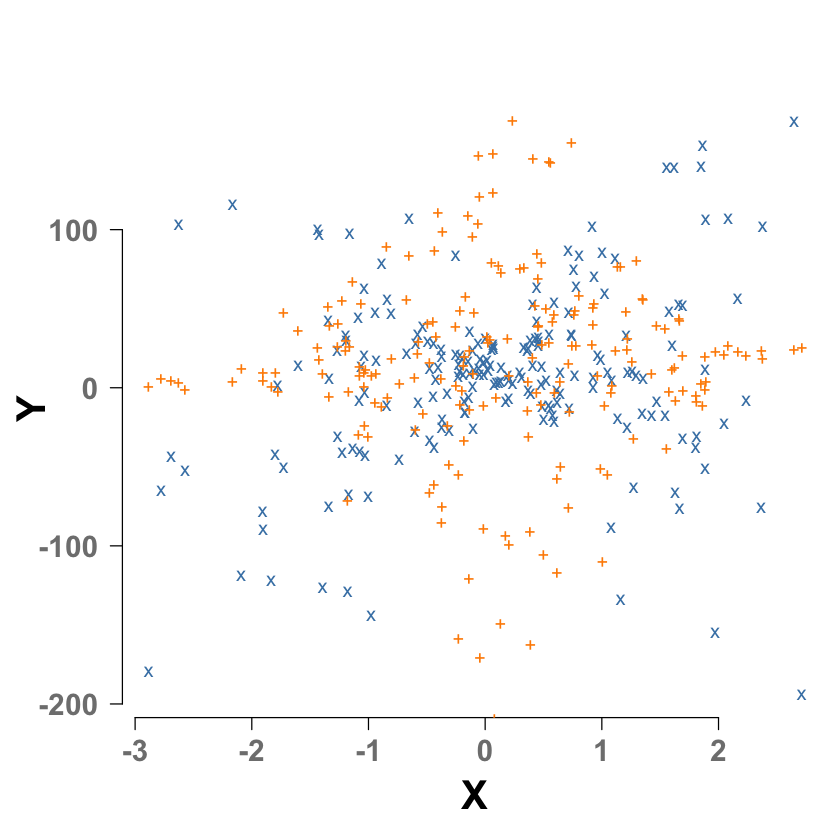

In [8]:
source("http://people.ischool.berkeley.edu/~d.alex.hughes/code/pubPlot.R")
d[ ,   plot(x, y1, pch = 'x', col = "steelblue", xlab = "X", ylab = "Y")]
d[ , points(x, y2, pch = '+', col = "darkorange")]

# Model 
Fit a model to this data using a simple `lm` call. Then, use the `r.se` function that we defined earlier to estimate both a robust standard error and also a *normal* standard error that assumes constant variance.

In [9]:
model_1      <- d[ , lm(y1 ~ x)]
model_1$r.se <- r.se(model = model_1, error.type = 'HC3')
model_1$se   <- r.se(model = model_1, error.type = 'const')

model_2      <- d[ , lm(y2 ~ x)]
model_2$r.se <- r.se(model = model_2, error.type = 'HC3')
model_2$se   <- r.se(model = model_2, error.type = 'const')

One important thing to note that is that both of these models actually have the same sum of squared residuals. That is, compared to the fit model, the deviations are the same. The difference, however, is the X-location of these deviations. 


In [10]:
model_1_residuals <- resid(model_1)
model_2_residuals <- resid(model_2)

sprintf('The mean residuals for model 1 are %.0f, and the mean residuals for model 2 are %.0f', 
        mean(model_1_residuals), mean(model_2_residuals))
sprintf('The median residual for model 1 are %.0f, and the median residual for model 2 are %.0f', 
        median(model_1_residuals), median(model_2_residuals))

[1] "The mean residuals for model 1 are -0, and the mean residuals for model 2 are -0"

[1] "The median residual for model 1 are 3, and the median residual for model 2 are 0"

# Print these tables 

Let's first print a table that includes the constant variance uncertainty estimator. 


In [12]:
stargazer(model_1, se = list(model_1$se), 
          type = "text", 
          title = "A regression table.", 
          header = FALSE)



A regression table.
                        Dependent variable:    
                    ---------------------------
                                y1             
-----------------------------------------------
x                            10.252***         
                              (3.462)          
                                               
Constant                      6.658*           
                              (3.925)          
                                               
-----------------------------------------------
Observations                    200            
R2                             0.042           
Adjusted R2                    0.038           
Residual Std. Error      55.262 (df = 198)     
F Statistic           8.771*** (df = 1; 198)   
Note:               *p<0.1; **p<0.05; ***p<0.01


# Show both the constant variance and the robust estimators. 

In [14]:
stargazer(model_1, model_1, model_2, model_2, 
          se = list(model_1$se, model_1$r.se, model_2$se, model_2$r.se), 
          add.lines = list(c("Robust SE", "No", "Yes", "No", "Yes")),
          type = "text", 
          title = "A regression table that includes a model with robust standard errors.", 
          omit.stat = c('ser', 'F'),
          header = FALSE)



A regression table that includes a model with robust standard errors.
                      Dependent variable:         
             -------------------------------------
                    y1                 y2         
                (1)      (2)      (3)       (4)   
--------------------------------------------------
x            10.252*** 10.252*   1.923     1.923  
              (3.462)  (5.546)  (4.136)   (1.768) 
                                                  
Constant      6.658*   6.658*  16.119*** 16.119***
              (3.925)  (3.929)  (4.690)   (4.661) 
                                                  
--------------------------------------------------
Robust SE       No       Yes      No        Yes   
Observations    200      200      200       200   
R2             0.042    0.042    0.001     0.001  
Adjusted R2    0.038    0.038   -0.004    -0.004  
Note:                  *p<0.1; **p<0.05; ***p<0.01


# Let's Unpack Those Models 

Let's consider what we've learned, and how this matters and is represented in our models. 

1. Note that the coefficient estimate for both models is identical. Because we have fixed $X$ and $Y$ data that does not change based on any assumptions we make about the structure of the variance in the Y, we generate the same estimate $\hat{\beta}_{1} = 9.66$. Note as well that the estimate for the intercept is identical. 
2. Even more, all of the other components of the model-level summaries are the same; or mostly. We have the same number of observations, we explain the same amount of variance with our model, and have the same residual standard error. I'll note that the F-Statistics and corresponding test values are actually not reported correctly in this model. If you want to get into it, we can talk about why, or you can read this post from [Stack Overflow](http://stats.stackexchange.com/questions/93787/f-test-formula-under-robust-standard-error). 
3. What has changed is our estimate of the standard error of both coefficients. Note that the standard error of the intercept hasn't actulaly changed that much. This is because we centered our X distribution around zero when we made it. Thus, any "wobbling" in the estimation of the line is still basically still passing through the same $x=0, y=12$ point. If we moved all of our X values five units right, we sould see somethign very different. 

NULL

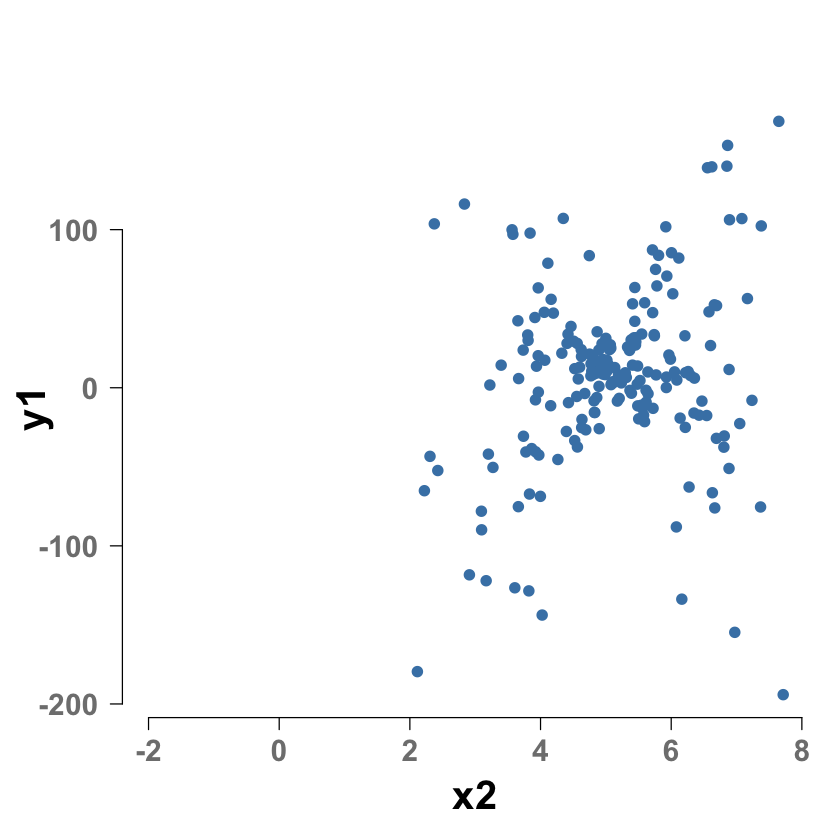

In [18]:
d[ , x2 := x + 5]

source("http://people.ischool.berkeley.edu/~d.alex.hughes/code/pubPlot.R")
d[ , plot(x2, y1, pch=19, col="steelblue", 
          xlim = c(-2, 8))]

model_3      <- d[ , lm(y1 ~ x2)]
model_3$r.se <- r.se(model = model_3, error.type = "HC3")
model_3$se   <- r.se(model = model_3, error.type = "const") 


In [20]:
stargazer(model_3, model_3, se = list(model_3$se, model_3$r.se), 
          add.lines = list(c("Robust SE", "No", "Yes")),
          type = "text", 
          title = "A regression table that includes a model with robust standard errors.", 
          header = FALSE)


A regression table that includes a model with robust standard errors.
                                   Dependent variable:     
                               ----------------------------
                                            y1             
                                    (1)            (2)     
-----------------------------------------------------------
x2                               10.252***       10.252*   
                                  (3.462)        (5.546)   
                                                           
Constant                         -44.601**       -44.601   
                                  (18.106)      (28.116)   
                                                           
-----------------------------------------------------------
Robust SE                            No            Yes     
Observations                        200            200     
R2                                 0.042          0.042    
Adjusted R2                  